In [297]:
import pandas as pd
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import time
import math
from IPython.display import Markdown, display
%matplotlib inline

def printmd(string):
    display(Markdown(string))

In [28]:
# Import data
wine = pd.read_csv('winequality-red.csv', sep = ';')

In [29]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [30]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [31]:
wine['class'] = ['Low' if i <= 5 else "High" for i in wine.quality]

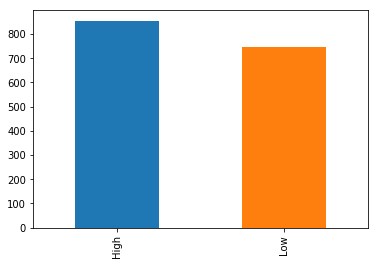

In [32]:
wine['class'].value_counts().plot(kind = 'bar')

In [33]:
# Dropping quality
wine.drop(columns = ['quality'], inplace = True)


In [43]:
wine_data = wine[wine.columns[wine.columns != 'class']]
wine_label = wine[wine.columns[wine.columns == 'class']]

In [47]:
train_data, test_data, train_label, test_label = train_test_split(wine_data, wine_label, train_size = 0.75, test_size = 0.25) 

In [48]:
train_data.shape


(1199, 11)

In [285]:
def euclidean_dist(x,y):
    return (math.sqrt(sum((pd.Series(x)-pd.Series(y))**2)))
    
    
def KNN(k, train_df, train_labels, test_df):
    out = []
    test_nums = test_df.shape[0]
    for i in range(test_nums):
        distances = train_data.apply(lambda x: euclidean_dist(x,test_df.iloc[i,:]), axis=1)
        distances_sorted = distances.sort_values().index
        distances_class = train_labels.loc[distances_sorted]['class']
        distances_class = distances_class[:k+1]
        res = distances_class.value_counts().index[0]
        out.append(res)
    return pd.Series(out)
        
        
        
def confusion(x,y):
    if len(x) != len(y):
        return 'Length do not match'
    y = list(y)
    TP, TN, FP, FN = 0,0,0,0
    for i in range(len(x)):

        if y[i] == 'High':
            if x[i] == 'High':
                TP += 1
            else:
                FN += 1
        else:
            if x[i] == 'High':
                FP += 1
            else:
                TN += 1
    return TP, FN, FP, TN
                
            
        

In [298]:
# Running KNN
start_time = time.time()
x = KNN(1, train_data, train_label, test_data)
print("--- %s seconds ---" % (time.time() - start_time))

1
(1199, 11)
(1199, 1)
(400, 11)
--- 157.51659607887268 seconds ---


In [295]:
x.value_counts()

High    277
Low     123
dtype: int64

In [296]:
TP, FN, FP, TN = confusion(a,b)
accuracy = ((TP+TN)*100)/(TP+FN+FP+TN)
precision = (TP*100)/(TP+FP)
recall = (TP*100)/(TP+FN)
accuracy, precision, recall

(66.25, 64.98194945848375, 82.56880733944953)

In [ ]:
'''x = test_data.iloc[0,:]
y = pd.DataFrame({'A':[1,2,3],'B':[1,2,3],'C':[1,2,3],'D':[1,2,3],'E':[1,2,3]})
f = pd.DataFrame({'F':['Top','Bottom','Top']})
x = y.iloc[1,:]
a = y.apply(lambda a: euclidean_dist(x,a), axis=1)
f.iloc[a.sort_values().index,:]['F'][:2].value_counts().index[0]'''